In [1]:
# imports

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from transformers import AutoImageProcessor, ResNetForImageClassification
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler
import torch
import torch.nn as nn
import torch_directml as dml
import torch.optim as optim
import math
import copy
import os
import cv2
import pickle
import time
import re
import shutil
import random
import psutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load csv files

# Load existing brands from combined_cars.csv
existing_csv_path = './processed_data/combined_cars.csv'
existing_df = pd.read_csv(existing_csv_path)
existing_brands = existing_df['Make'].unique()

# Load all car brands from the new CSV
all_brands_csv_path = './processed_data/all_car_brands.csv'
all_brands_df = pd.read_csv(all_brands_csv_path)

# Check the structure of the new CSV to determine the column name
print("Columns in all_brands_df:", all_brands_df.columns.tolist())

# Assuming the column name is "Brand" - adjust if different
all_brands = all_brands_df['Brand'].unique() if 'Brand' in all_brands_df.columns else all_brands_df.iloc[:,0].unique()

# Create lowercase versions for comparison
existing_brands_lower = [brand.lower() for brand in existing_brands]
all_brands_lower = [brand.lower() for brand in all_brands]

# Find missing brands (case-insensitive)
missing_brands = [brand for i, brand in enumerate(all_brands) 
                 if all_brands_lower[i] not in existing_brands_lower]

print(f"Existing brands: {len(existing_brands)}")
print(f"All brands: {len(all_brands)}")
print(f"Missing brands: {len(missing_brands)}")
print("\nMissing brands:")
print(missing_brands)

# Brand mapping dictionary
brand_mapping = {
    # Common abbreviations
    'bmw': 'BMW',
    'vw': 'VOLKSWAGEN',
    'benz': 'MERCEDES-BENZ',
    'merc': 'MERCEDES-BENZ',
    'mercedes': 'MERCEDES-BENZ',
    'amg': 'Mercedes-AMG',
    'chevy': 'CHEVROLET',
    'caddy': 'CADILLAC',
    'lambo': 'LAMBORGHINI',
    'alfa': 'ALFA ROMEO',
    'aston': 'ASTON MARTIN',
    'rolls': 'ROLLS-ROYCE',
    'rr': 'ROLLS-ROYCE',
    'land': 'LAND ROVER',
    'rover': 'LAND ROVER',
    'landrover': 'LAND ROVER',
    'buggy': 'BUGATTI',
    'bentley': 'BENTLEY',
    'toyota': 'TOYOTA',
    'lexus': 'LEXUS',
    'nissan': 'NISSAN',
    'honda': 'HONDA',
    'mazda': 'MAZDA',
    'suzuki': 'SUZUKI',
    'kia': 'KIA',
    'hyundai': 'HYUNDAI',
    'porsche': 'PORSCHE',
    'tesla': 'TESLA',
    'maserati': 'MASERATI',
    'volvo': 'VOLVO',
    'subaru': 'SUBARU',
    'jaguar': 'JAGUAR',
    'jeep': 'JEEP',
    'mini': 'MINI',
    'ford': 'FORD',
    'fiat': 'FIAT',
    'ferrari': 'FERRARI',
    'citroen': 'CITROEN',
    'audi': 'AUDI',
    'acura': 'ACURA',
    'peugeot': 'PEUGEOT',
    'renault': 'RENAULT',
    'skoda': 'SKODA',
    'seat': 'SEAT',
    'opel': 'OPEL',
    'lancia': 'LANCIA',
    'lotus': 'LOTUS',
    'london taxi': 'LONDON TAXI',
    'mclaren': 'MCLAREN',
    'mc': 'MCLAREN',
    'mitsu': 'MITSUBISHI',
    'mitsubishi': 'MITSUBISHI',
    'dodge': 'DODGE',
    'ram': 'RAM',
    'gmc': 'GMC',
    'buick': 'BUICK',
    'lincoln': 'LINCOLN',
    'chrysler': 'CHRYSLER',
    'infin': 'INFINITI',
    'infiniti': 'INFINITI',
    'ssang': 'SSANGYONG',
    'ssangyong': 'SSANGYONG',
    
    # Model identifiers that indicate brand
    'mustang': 'FORD',
    'camaro': 'CHEVROLET',
    'corvette': 'CHEVROLET',
    'prius': 'TOYOTA',
    'accord': 'HONDA',
    'civic': 'HONDA',
    'camry': 'TOYOTA',
    'wrangler': 'JEEP',
    '911': 'PORSCHE',
    'model3': 'TESLA',
    'models': 'TESLA',
    'modelx': 'TESLA',
    'modely': 'TESLA',
    'cybertruck': 'TESLA',
    'f150': 'FORD',
    'ranger': 'FORD',
    'giulia': 'ALFA ROMEO',
    'stelvio': 'ALFA ROMEO',
    'a4': 'AUDI',
    'q5': 'AUDI',
    'tt': 'AUDI',
    'x5': 'BMW',
    'x3': 'BMW',
    '325': 'BMW',
    '330': 'BMW',
    '530': 'BMW',
    'escalade': 'CADILLAC',
    'tahoe': 'CHEVROLET',
    'silverado': 'CHEVROLET',
    'challenger': 'DODGE',
    'charger': 'DODGE',
    'california': 'FERRARI',
    'f430': 'FERRARI',
    '458': 'FERRARI',
    '488': 'FERRARI',
    'focus': 'FORD',
    'escape': 'FORD',
    'bronco': 'FORD',
    'cr-v': 'HONDA',
    'cr-z': 'HONDA',
    'santa': 'HYUNDAI',
    'tucson': 'HYUNDAI',
    'elantra': 'HYUNDAI',
    'cherokee': 'JEEP',
    'compass': 'JEEP',
    'sorento': 'KIA',
    'sportage': 'KIA',
    'gallardo': 'LAMBORGHINI',
    'huracan': 'LAMBORGHINI',
    'aventador': 'LAMBORGHINI',
    'urus': 'LAMBORGHINI',
    'rx': 'LEXUS',
    'is': 'LEXUS',
    'es': 'LEXUS',
    'london taxi': 'LONDON TAXI',
    'ghibli': 'MASERATI',
    'levante': 'MASERATI',
    'miata': 'MAZDA',
    'mx5': 'MAZDA',
    'mx-5': 'MAZDA',
    'cx5': 'MAZDA',
    'cx-5': 'MAZDA',
    'cclass': 'MERCEDES-BENZ',
    'c-class': 'MERCEDES-BENZ',
    'eclass': 'MERCEDES-BENZ',
    'e-class': 'MERCEDES-BENZ',
    'sclass': 'MERCEDES-BENZ',
    's-class': 'MERCEDES-BENZ',
    'gclass': 'MERCEDES-BENZ',
    'g-class': 'MERCEDES-BENZ',
    'countryman': 'MINI',
    'cooper': 'MINI',
    'lancer': 'MITSUBISHI',
    'outlander': 'MITSUBISHI',
    'eclipse': 'MITSUBISHI',
    'altima': 'NISSAN',
    'maxima': 'NISSAN',
    'skyline': 'NISSAN',
    'gtr': 'NISSAN',
    'gt-r': 'NISSAN',
    '370z': 'NISSAN',
    'cayman': 'PORSCHE',
    'cayenne': 'PORSCHE',
    'macan': 'PORSCHE',
    'panamera': 'PORSCHE',
    'megane': 'RENAULT',
    'clio': 'RENAULT',
    'ghost': 'ROLLS-ROYCE',
    'phantom': 'ROLLS-ROYCE',
    'cullinan': 'ROLLS-ROYCE',
    'forester': 'SUBARU',
    'impreza': 'SUBARU',
    'outback': 'SUBARU',
    'wrx': 'SUBARU',
    'sti': 'SUBARU',
    'corolla': 'TOYOTA',
    'supra': 'TOYOTA',
    'rav4': 'TOYOTA',
    'land_cruiser': 'TOYOTA',
    'landcruiser': 'TOYOTA',
    'golf': 'VOLKSWAGEN',
    'passat': 'VOLKSWAGEN',
    'jetta': 'VOLKSWAGEN',
    'tiguan': 'VOLKSWAGEN',
    'beetle': 'VOLKSWAGEN',
    'xc90': 'VOLVO',
    'xc60': 'VOLVO',
    'v60': 'VOLVO',
    's60': 'VOLVO',
}

Columns in all_brands_df: ['name']
Existing brands: 157
All brands: 124
Missing brands: 46

Missing brands:
['AC', 'ALPINE', 'ARIEL', 'ARO', 'ARTEGA', 'AURUS', 'BRISTOL', 'BUFORI', 'CATERHAM', 'CITROEN', 'CUPRA', 'DeLorean', 'DONKERVOORT', 'DR MOTOR', 'DS AUTOMOBILES', 'FSO', 'GEELY', 'GORDON MURRAY Automotive', 'GTA Motor', 'HINDUSTAN', 'HOLDEN', 'INEOS', 'KTM', 'LADA', 'LANCIA', 'LIGHTYEAR', 'Lucid Motors', 'MARUSSIA', 'MARUTI SUZUKI', 'Mercedes-AMG', 'NIO', 'OPEL', 'PERODUA', 'PROTON', 'QOROS', 'RIMAC', 'SAMSUNG', 'SANTANA', 'SEAT', 'SSANGYONG', 'TATA MOTORS', 'VAUXHALL', 'WIESMANN', 'Xpeng', 'ZENDER', 'Zenvo']


In [5]:
# Loading all brands & preparing the retraining

def prepare_dataset_with_stratified_splits(source_dir, output_dir='./data', 
                                          all_brands=None, train_split=0.7, valid_split=0.15,
                                          min_per_split=5):
    """
    Prepare a dataset with stratified splits to ensure each class has representation
    in all train/valid/test splits.
    """
    max_images_per_class = 1000
    
    # Add all brands to the mapping (keeping original case)
    for brand in all_brands:
        brand_lower = brand.lower()
        brand_mapping[brand_lower] = brand
    
    # Create output directories if they don't exist
    for split_dir in [os.path.join(output_dir, split) for split in ['train', 'valid', 'test']]:
        os.makedirs(split_dir, exist_ok=True)
    
    # Get all images
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)
    
    print(f"Found {len(image_files)} images in {source_dir}")
    
    # First pass: Identify class for each image
    print("Scanning images to identify classes...")
    image_classes = {}
    found_classes = set()
    
    # Process each image to determine its class
    for img_file in tqdm(image_files, desc="Identifying image classes"):
        img_file_lower = img_file.lower()
        img_class = None
        
        # Use your existing class identification logic...
        words = img_file_lower
        for sep in ['.', '_', '-', ' ']:
            words = words.replace(sep, ' ')
        words = words.split()
        
        # Try word-based matching
        for word in words:
            if word in brand_mapping:
                img_class = brand_mapping[word]
                found_classes.add(img_class)
                break
        
        # Try other matching approaches if needed
        if img_class is None:
            for brand in all_brands:
                if brand.lower() in img_file_lower:
                    img_class = brand
                    found_classes.add(brand)
                    break
        
        # Default to 'other' if no match
        if img_class is None:
            img_class = 'other'
            found_classes.add('other')
        
        # Store the class for this image
        image_classes[img_file] = img_class
    
    # Group images by class
    class_images = {}
    for cls in found_classes:
        class_images[cls] = [img for img, img_class in image_classes.items() if img_class == cls]
        print(f"Class {cls}: {len(class_images[cls])} images")
    
    # Create stratified splits ensuring minimum samples per split
    split_assignments = {}  # {image_file: split}
    class_distribution = {cls: {'train': 0, 'valid': 0, 'test': 0} for cls in found_classes}
    
    for cls, imgs in class_images.items():
        # Limit max images per class
        if len(imgs) > max_images_per_class:
            imgs = random.sample(imgs, max_images_per_class)
        
        # Calculate target counts for each split
        total = len(imgs)
        train_target = int(total * train_split)
        valid_target = int(total * valid_split)
        test_target = total - train_target - valid_target
        
        # Ensure minimum samples per split
        if valid_target < min_per_split and total >= 3*min_per_split:
            # Adjust to guarantee minimum samples in validation
            valid_target = min_per_split
            remaining = total - valid_target
            train_target = int(remaining * (train_split/(train_split+valid_split)))
            test_target = total - train_target - valid_target
        
        if test_target < min_per_split and total >= 3*min_per_split:
            # Adjust to guarantee minimum samples in test
            test_target = min_per_split
            remaining = total - test_target
            train_target = int(remaining * (train_split/(train_split+valid_split)))
            valid_target = total - train_target - test_target
        
        # If class is very small, distribute as evenly as possible
        if total < 3*min_per_split:
            if total >= 3:  # At least one for each split
                test_target = max(1, total // 5)
                valid_target = max(1, total // 5)
                train_target = total - valid_target - test_target
            else:
                # If extremely small, put all in training
                train_target = total
                valid_target = 0
                test_target = 0
        
        # Shuffle images of this class
        random.shuffle(imgs)
        
        # Assign splits
        idx = 0
        for _ in range(train_target):
            if idx < len(imgs):
                split_assignments[imgs[idx]] = 'train'
                class_distribution[cls]['train'] += 1
                idx += 1
                
        for _ in range(valid_target):
            if idx < len(imgs):
                split_assignments[imgs[idx]] = 'valid'
                class_distribution[cls]['valid'] += 1
                idx += 1
                
        for _ in range(test_target):
            if idx < len(imgs):
                split_assignments[imgs[idx]] = 'test'
                class_distribution[cls]['test'] += 1
                idx += 1
    
    # Process and save images according to their split assignments
    errors = []
    
    for img_file, split in tqdm(split_assignments.items(), desc="Processing images"):
        try:
            # Source path
            src_path = os.path.join(source_dir, img_file)
            
            # Get class and format directory name
            img_class = image_classes[img_file]
            class_dir_name = img_class.replace(' ', '_')
            
            # Destination directory
            dst_dir = os.path.join(output_dir, split, class_dir_name)
            os.makedirs(dst_dir, exist_ok=True)
            
            # Resize and save the image
            img = cv2.imread(src_path)
            if img is None:
                errors.append(f"Warning: Could not read image {src_path}")
                continue
            
            img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
            dst_path = os.path.join(dst_dir, img_file)
            cv2.imwrite(dst_path, img_resized)
            
        except Exception as e:
            errors.append(f"Error processing {img_file}: {str(e)}")
    
    # Print distribution summary
    print("\nClass distribution across splits:")
    for cls in sorted(found_classes):
        train_count = class_distribution[cls]['train']
        valid_count = class_distribution[cls]['valid']
        test_count = class_distribution[cls]['test']
        total = train_count + valid_count + test_count
        
        print(f"{cls}: Total={total}, Train={train_count}, Valid={valid_count}, Test={test_count}")
    
    # Print errors if any
    if errors:
        print("\nErrors encountered:")
        for error in errors[:10]:  # Show only first 10 errors
            print(error)
        if len(errors) > 10:
            print(f"...and {len(errors) - 10} more errors")
    
    return list(found_classes)


# Prepare the updated dataset
new_folder_path = './images/cars5'  # Path to your new folder with car images
    
print("Preparing dataset with all car brands...")
class_names = prepare_dataset_with_stratified_splits(
    source_dir=new_folder_path,
    output_dir='./data',
    all_brands=all_brands,
    min_per_split=5  # Set minimum samples per split
)

Preparing dataset with all car brands...
Found 270527 images in ./images/cars5
Scanning images to identify classes...


Identifying image classes: 100%|██████████| 270527/270527 [00:00<00:00, 574338.58it/s]


Class BMW: 20648 images
Class SATURN: 206 images
Class AUDI: 15848 images
Class DAEWOO: 333 images
Class NISSAN: 10023 images
Class SUBARU: 4088 images
Class DAIHATSU: 285 images
Class MAYBACH: 543 images
Class ROLLS-ROYCE: 1076 images
Class SPYKER: 218 images
Class Zenvo: 113 images
Class FIAT: 4737 images
Class MINI: 2583 images
Class other: 1535 images
Class SSANGYONG: 699 images
Class HUMMER: 187 images
Class FISKER: 22 images
Class CUPRA: 135 images
Class MG: 459 images
Class OPEL: 3703 images
Class CATERHAM: 23 images
Class BUGATTI: 641 images
Class HONDA: 7593 images
Class LIGHTYEAR: 24 images
Class LAND ROVER: 2965 images
Class OLDSMOBILE: 184 images
Class PEUGEOT: 4793 images
Class LEXUS: 6394 images
Class BUFORI: 41 images
Class ACURA: 2606 images
Class LINCOLN: 2737 images
Class PROTON: 235 images
Class GENESIS: 942 images
Class KOENIGSEGG: 369 images
Class QOROS: 74 images
Class ALPINE: 113 images
Class MASERATI: 2196 images
Class Polestar: 181 images
Class PORSCHE: 9291 im

Processing images: 100%|██████████| 64781/64781 [12:23<00:00, 87.11it/s] 


Class distribution across splits:
AC: Total=1000, Train=700, Valid=150, Test=150
ACURA: Total=1000, Train=700, Valid=150, Test=150
ALFA ROMEO: Total=1000, Train=700, Valid=150, Test=150
ALPINE: Total=113, Train=79, Valid=16, Test=18
ASTON MARTIN: Total=1000, Train=700, Valid=150, Test=150
AUDI: Total=1000, Train=700, Valid=150, Test=150
AURUS: Total=52, Train=36, Valid=7, Test=9
BENTLEY: Total=1000, Train=700, Valid=150, Test=150
BMW: Total=1000, Train=700, Valid=150, Test=150
BRISTOL: Total=31, Train=21, Valid=5, Test=5
BUFORI: Total=41, Train=28, Valid=6, Test=7
BUGATTI: Total=641, Train=448, Valid=96, Test=97
BUICK: Total=1000, Train=700, Valid=150, Test=150
CADILLAC: Total=1000, Train=700, Valid=150, Test=150
CATERHAM: Total=23, Train=14, Valid=4, Test=5
CHEVROLET: Total=1000, Train=700, Valid=150, Test=150
CHRYSLER: Total=1000, Train=700, Valid=150, Test=150
CITROEN: Total=1000, Train=700, Valid=150, Test=150
CUPRA: Total=135, Train=94, Valid=20, Test=21
DACIA: Total=1000, Train=

In [6]:
# dataset functions


def filter_out_other_class(base_dir):
    """
    Remove the 'other' class folder from all dataset splits
    """
    for split in ['train', 'valid', 'test']:
        other_dir = os.path.join(base_dir, split, 'other')
        if os.path.exists(other_dir):
            print(f"Removing 'other' class from {split} split")
            shutil.rmtree(other_dir)
            print(f"Removed: {other_dir}")
        else:
            print(f"No 'other' class found in {split} split")
    
    print("Removed 'other' class from all dataset splits")
    
    
# Modified dataset loading code with error handling
def create_image_datasets(base_dir, data_transforms):
    """Create image datasets with error handling for empty class directories"""
    datasets_dict = {}
    
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(base_dir, split)
        
        # Get list of non-empty class directories
        valid_classes = []
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.isdir(class_dir):
                # Check if directory has at least one valid image
                valid_files = [f for f in os.listdir(class_dir) 
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if valid_files:
                    valid_classes.append(class_name)
                else:
                    # Remove empty directory to avoid future errors
                    print(f"Removing empty class directory: {class_dir}")
                    shutil.rmtree(class_dir)
        
        print(f"Found {len(valid_classes)} valid classes in {split} split")
        
        # Create dataset with only valid classes
        try:
            datasets_dict[split] = datasets.ImageFolder(split_dir, transform=data_transforms[split])
        except Exception as e:
            print(f"Error loading {split} dataset: {str(e)}")
            # Create empty dataset as fallback
            datasets_dict[split] = None
    
    return datasets_dict


In [8]:
# Processing the transforms & dataloaders with caching

import pickle

# Define data transforms (same as before)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256), # 224 originally
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.4),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}



# Define the cache path
cache_path = './cache/data_cache.pkl'

# Check if cache exists and is valid
cache_valid = False
if os.path.exists(cache_path):
    try:
        # Check if the cache is newer than the data directory
        cache_time = os.path.getmtime(cache_path)
        data_time = os.path.getmtime('./data')
        
        if cache_time > data_time:
            cache_valid = True
        else:
            print("Cache exists but data directory has been modified. Rebuilding cache...")
    except Exception as e:
        print(f"Error checking cache validity: {e}")

# Use cache if it exists and is valid
if cache_valid:
    print("Loading datasets from cache...")
    try:
        with open(cache_path, 'rb') as f:
            cached_data = pickle.load(f)
            
        image_datasets = cached_data['image_datasets']
        class_names = cached_data['class_names']
        class_weights_tensor = cached_data['class_weights_tensor']
        class_weights = cached_data['class_weights']
        num_classes = cached_data['num_classes']
        
        print(f"Successfully loaded cached datasets with {num_classes} classes")
        
    except Exception as e:
        print(f"Error loading from cache: {e}")
        cache_valid = False

# If no valid cache, create datasets the normal way
if not cache_valid:
    print("Creating datasets from scratch (this may take a while)...")
    
    # First run the filtering function
    filter_out_other_class(data_dir)
    
    # Use the function to create datasets
    image_datasets = create_image_datasets(data_dir, data_transforms)
    
    # Calculate class weights
    class_counts = Counter([label for _, label in image_datasets['train']])
    total_samples = sum(class_counts.values())
    
    # Get actual classes from the dataset
    actual_class_names = image_datasets['train'].classes
    num_classes = len(actual_class_names)
    
    # Convert class weights to a tensor
    class_weights = {cls: math.sqrt(total_samples / class_counts.get(cls, 1)) for cls in range(num_classes)}
    
    # Handle missing classes in train_dataset
    class_weights_tensor = torch.zeros(num_classes, dtype=torch.float).to(dml_device)
    for cls, weight in class_weights.items():
        if cls < len(class_weights_tensor):
            class_weights_tensor[cls] = weight
    
    class_names = actual_class_names
    
    # Save to cache for future use
    print("Saving datasets to cache for faster loading next time...")
    cache_data = {
        'image_datasets': image_datasets,
        'class_names': class_names,
        'class_weights_tensor': class_weights_tensor,
        'class_weights': class_weights,
        'num_classes': num_classes
    }
    
    try:
        with open(cache_path, 'wb') as f:
            pickle.dump(cache_data, f)
        print(f"Cache saved to {cache_path}")
    except Exception as e:
        print(f"Error saving cache: {e}")

# Hyperparameters
batch_size = 16
num_epochs = 100

# Prepare dataloaders (always do this part fresh)
print(f"Number of actual classes in dataset: {num_classes}")

# Assign weights to each sample
sample_weights = [class_weights[label] for _, label in image_datasets['train']]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create dataloaders
print(f"Creating dataloaders with batch size = {batch_size}")
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler, num_workers=4),
    'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['valid'] is not None else None,
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['test'] is not None else None,
}

# Create datasets (already done above as image_datasets)
standard_datasets = image_datasets

print(f"Creating dataloaders with batch size = {batch_size}")
dataloaders = {
    'train': DataLoader(standard_datasets['train'], batch_size=batch_size, 
                        sampler=sampler, num_workers=4),
    'valid': DataLoader(standard_datasets['valid'], batch_size=batch_size, 
                        shuffle=False, num_workers=4) if standard_datasets['valid'] is not None else None,
    'test': DataLoader(standard_datasets['test'], batch_size=batch_size, 
                       shuffle=False, num_workers=4) if standard_datasets['test'] is not None else None
}


#print(f"Training with learning rate: {learning_rate}")
print(f"Shape of class_weights_tensor: {class_weights_tensor.shape}")
print(f"Expected number of classes: {num_classes}")
print("\nTesting if dataloader works...")
try:
    test_batch = next(iter(dataloaders['train']))
    print(f"Successfully loaded a batch with shape: {test_batch[0].shape}")
    print(f"Labels shape: {test_batch[1].shape}")
    print(f"First few labels: {test_batch[1][:5]}")
except Exception as e:
    print(f"Error loading batch: {str(e)}")

Loading datasets from cache...
Successfully loaded cached datasets with 95 classes
Number of actual classes in dataset: 95
Creating dataloaders with batch size = 16
Creating dataloaders with batch size = 16
Shape of class_weights_tensor: torch.Size([95])
Expected number of classes: 95

Testing if dataloader works...
Successfully loaded a batch with shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
First few labels: tensor([52, 48, 87, 42,  4])


In [9]:
# Training functions for the ResNet Model


# Configure DirectML
dml_device = dml.device(dml.default_device())
print(f"Using DirectML device: {dml.device_name(dml.default_device())}")

# Define paths
#source_dir = './images/cars'  # Source directory containing all images
source_dir = './images/cars2'
data_dir = './data'  # Output directory for train, valid, and test splits
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Initialize "variable" connection with the GPU
device = dml_device

torch.backends.cudnn.benchmark = True  # Speed up training



Using DirectML device: AMD  Radeon RX 7800 XT 


Loading model...


C:\Users\lalad\AppData\Local\Temp\ipykernel_8056\1749429074.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./best_resnet_car_classifier.pth')


Testing with a random image:
Selected image: Buick_Enclave_2011_37_19_280_36_6_79_72_201_16_AWD_7_4_SUV_QyE.jpg


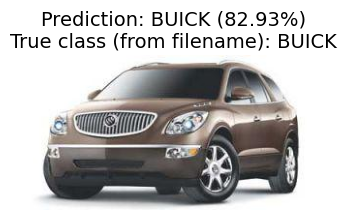


Testing with multiple random images:


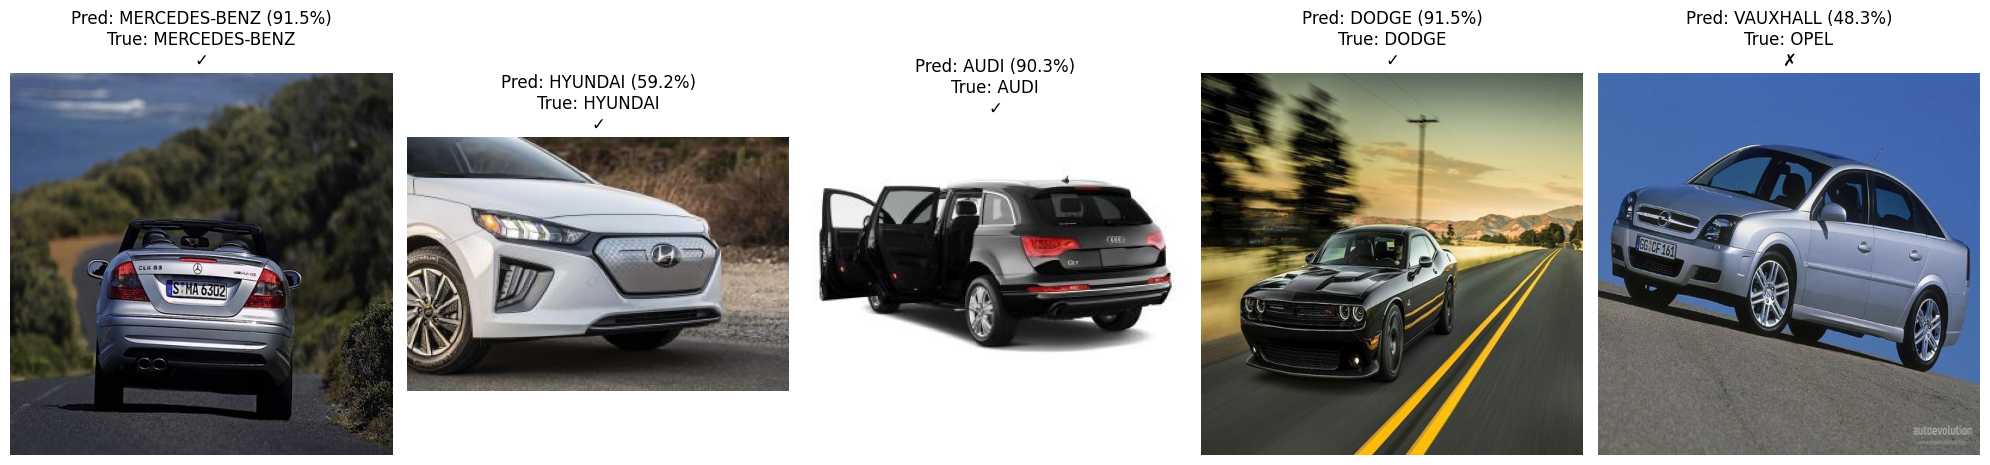

In [509]:
def test_with_random_image(model, class_names, device, data_dir='./images/cars', test_transform=None):
    """Test the model with a random car image"""
    # Get a random image from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    img_file = random.choice(image_files)
    img_path = os.path.join(data_dir, img_file)
    print(f"Selected image: {img_file}")
    
    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(image).unsqueeze(0).to(device)
    
    # Try to determine true label from filename
    true_class = "Unknown"
    for make in class_names:
        if make.lower() in img_file.lower():
            true_class = make
            break
    
    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        # Extract logits from output object
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
        probs = torch.nn.functional.softmax(logits, dim=1)[0]
        _, pred_idx = torch.max(logits, 1)
    
    # Get prediction results
    pred_class = class_names[pred_idx.item()]
    confidence = probs[pred_idx.item()].item() * 100
    
    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)\nTrue class (from filename): {true_class}", fontsize=14)
    plt.show()
    
    # Get top 5 predictions
    top_k = min(5, len(class_names))
    top_probs, top_idx = torch.topk(probs, top_k)
    top_classes = [class_names[idx.item()] for idx in top_idx]
    top_confidences = [prob.item() * 100 for prob in top_probs]
    
    # Show top predictions
    # plt.figure(figsize=(10, 6))
    # plt.barh(range(top_k), top_confidences, color='skyblue')
    # plt.yticks(range(top_k), top_classes)
    # plt.xlabel('Confidence (%)')
    # plt.title('Top Predictions')
    # plt.gca().invert_yaxis()  # Highest confidence at the top
    # plt.tight_layout()
    # plt.show()
    
    return pred_class, confidence, true_class

# Test multiple random images
def test_multiple_random_images(model, class_names, device, data_dir='./images/cars', 
                               test_transform=None, num_images=5):
    """Test model with multiple random images with error handling for class index mismatches"""
    # Get random images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Check model output size vs class_names
    #print(f"Class names length: {len(class_names)}")
    # Check model output size by getting the final layer's output dimension
    output_size = None
    if hasattr(model, 'fc'):
        if isinstance(model.fc, nn.Sequential):
            # Find the Linear layer within Sequential
            for layer in model.fc:
                if isinstance(layer, nn.Linear):
                    output_size = layer.out_features
        elif hasattr(model.fc, 'out_features'):
            output_size = model.fc.out_features
    
    #print(f"Model output size: {output_size}")
    if output_size and output_size != len(class_names):
        print(f"WARNING: Model output size ({output_size}) doesn't match class_names length ({len(class_names)})")
        print("This will cause index errors when predictions are out of range")
    
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(random_images), figsize=(20, 5))
    if len(random_images) == 1:
        axes = [axes]
    
    results = []
    
    # Process each image
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(data_dir, img_file)
        
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(image).unsqueeze(0).to(device)
        
        # Try to determine true class
        true_class = "Unknown"
        for make in class_names:
            if make.lower() in img_file.lower():
                true_class = make
                break

        with torch.no_grad():
            outputs = model(img_tensor)
            # Extract logits from output object
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
            probs = torch.nn.functional.softmax(logits, dim=1)[0]
            _, pred_idx = torch.max(logits, 1)
            
            # Get prediction details for debugging
            predicted_index = pred_idx.item()
            confidence = probs[predicted_index].item() * 100
            
        # Safely get predicted class name
        try:
            pred_class = class_names[predicted_index]
        except IndexError:
            print(f"WARNING: Predicted index {predicted_index} is out of range for class_names list (length {len(class_names)})")
            pred_class = f"Unknown (idx={predicted_index})"
        
        # Display image with prediction
        axes[i].imshow(image)
        axes[i].axis('off')
        correct = "✓" if pred_class.replace('_', ' ') == true_class else "✗"
        axes[i].set_title(f"Pred: {pred_class} ({confidence:.1f}%)\nTrue: {true_class}\n{correct}")
        
        results.append((pred_class, confidence, true_class))
    
    plt.tight_layout()
    plt.show()
    return results

# Load the trained model
print("Loading model...")
checkpoint = torch.load('./best_resnet_car_classifier.pth')
#model = models.resnext101_32x8d(weights='IMAGENET1K_V2')
model = models.resnet50(weights='IMAGENET1K_V2')
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, num_classes)
)
model = model.to(device)
model.load_state_dict(torch.load('./best_resnet_car_classifier.pth'))

# Test with a single random image
print("\nTesting with a random image:")
pred_class, confidence, true_class = test_with_random_image(
    model=model,
    class_names=class_names,
    device=device,
    data_dir='./images/cars5',
    test_transform=data_transforms['test']
)

# Test with multiple random images
print("\nTesting with multiple random images:")
results = test_multiple_random_images(
    model=model,
    class_names=class_names,
    device=device,
    data_dir='./images/cars5',
    test_transform=data_transforms['test'],
    num_images=5
)


Testing with images of unknown class:
Found 5599 images with unknown class (filename doesn't match any known brand)


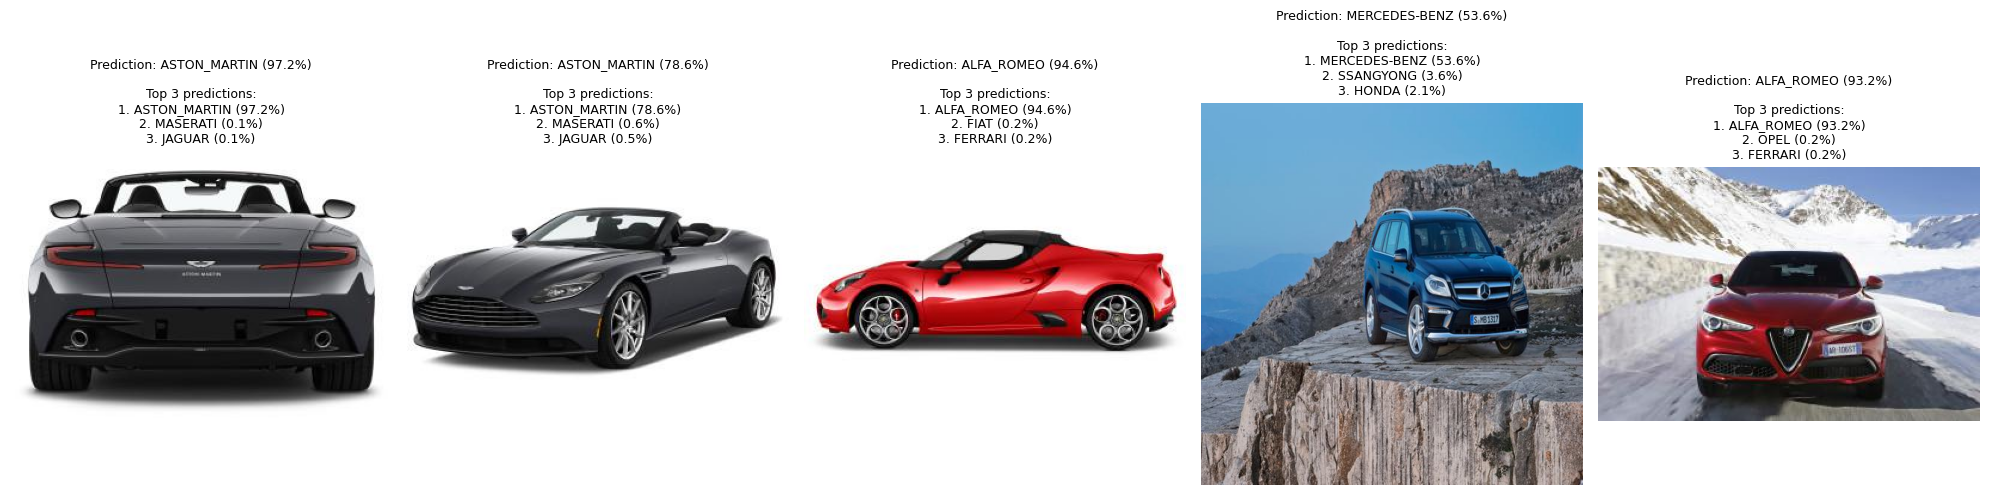

In [340]:
def test_unknown_class_images(model, class_names, device, data_dir='./images/cars', 
                             test_transform=None, num_images=5):
    """Test model with images where the true class cannot be determined from filename"""
    # Get all images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Filter to find images where filename doesn't match any known class
    unknown_images = []
    for img_file in image_files:
        img_file_lower = img_file.lower()
        is_unknown = True
        
        # Check if any class name appears in the filename
        for make in class_names:
            if make.lower() in img_file_lower:
                is_unknown = False
                break
                
        if is_unknown:
            unknown_images.append(img_file)
    
    if not unknown_images:
        print("No images with unknown class found. All filenames contain a known class name.")
        return
    
    print(f"Found {len(unknown_images)} images with unknown class (filename doesn't match any known brand)")
    
    # Sample from the unknown images
    selected_images = random.sample(unknown_images, min(num_images, len(unknown_images)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(selected_images), figsize=(20, 5))
    if len(selected_images) == 1:
        axes = [axes]
    
    results = []
    
    # Process each image
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(data_dir, img_file)
        
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_tensor)
            # Extract logits from output object
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
            probs = torch.nn.functional.softmax(logits, dim=1)[0]
            _, pred_idx = torch.max(logits, 1)
            
            # Get prediction details
            predicted_index = pred_idx.item()
            confidence = probs[predicted_index].item() * 100
            
        # Safely get predicted class name
        try:
            pred_class = class_names[predicted_index]
        except IndexError:
            print(f"WARNING: Predicted index {predicted_index} is out of range")
            pred_class = f"Unknown (idx={predicted_index})"
        
        # Get top 3 predictions
        top_k = min(3, len(class_names))
        top_probs, top_idx = torch.topk(probs, top_k)
        top_classes = [(class_names[idx.item()], prob.item() * 100) for idx, prob in zip(top_idx, top_probs)]
        
        # Display image with prediction
        axes[i].imshow(image)
        axes[i].axis('off')
        title = f"Prediction: {pred_class} ({confidence:.1f}%)\n\nTop 3 predictions:"
        for j, (name, score) in enumerate(top_classes):
            title += f"\n{j+1}. {name} ({score:.1f}%)"
            
        axes[i].set_title(title, fontsize=9)
        results.append((img_file, pred_class, confidence, top_classes))
    
    plt.tight_layout()
    plt.show()
    return results

# Example usage:
print("\nTesting with images of unknown class:")
unknown_results = test_unknown_class_images(
    model=model,
    class_names=class_names,
    device=device,
    data_dir='./images/cars5',
    test_transform=data_transforms['test'],
    num_images=5
)

____

Processing 10 images to find predictions with confidence between 70.0% and 99%...


100%|██████████| 10/10 [00:00<00:00, 82.65it/s]

Found 4 images with confidence between 70.0% and 99%


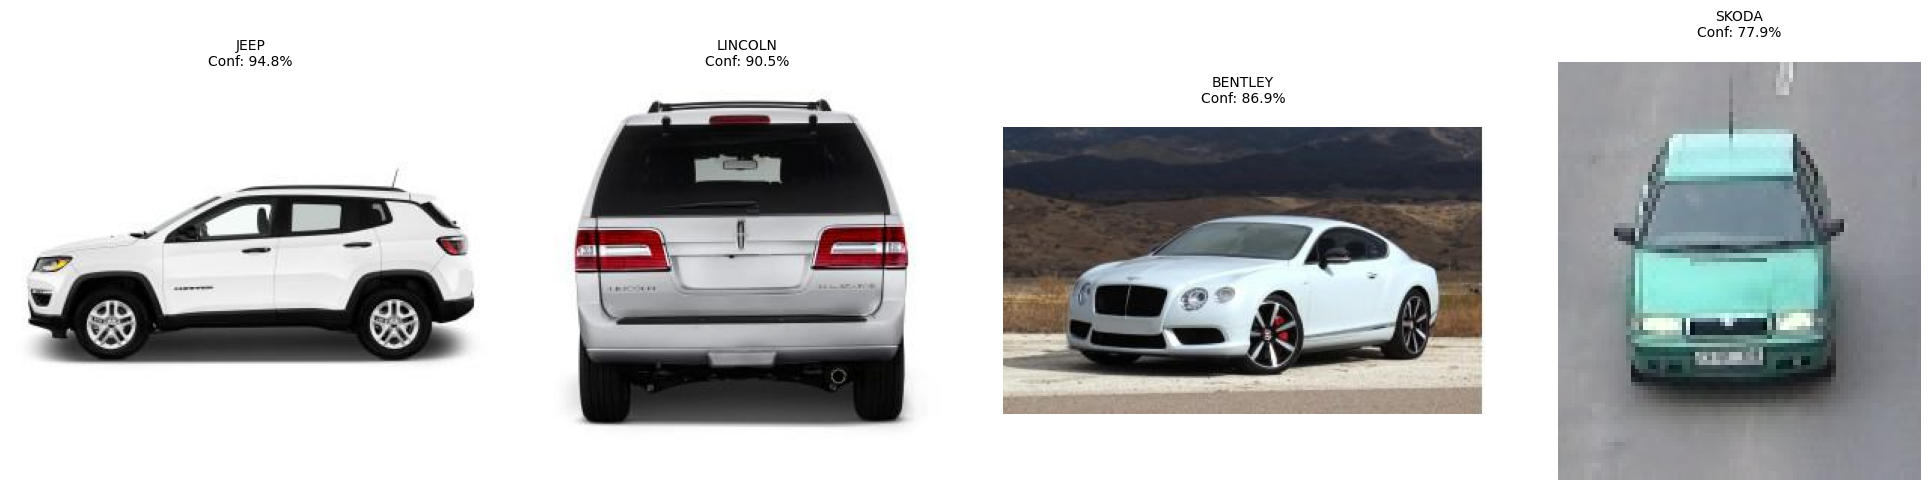

In [513]:
# high conf images

def test_confidence_range_images(model, class_names, device, data_dir='./images/cars', 
                              test_transform=None, min_confidence=60.0, max_confidence=100, num_samples=50):
    """Test model with random images but only display those with confidence predictions in specified range"""
    # Get random images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Sample images
    random_images = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Store results in confidence range
    range_confidence_results = []
    
    # Process each image and find predictions in confidence range
    print(f"Processing {len(random_images)} images to find predictions with confidence between {min_confidence}% and {max_confidence}%...")
    for img_file in tqdm(random_images):
        img_path = os.path.join(data_dir, img_file)
        
        try:
            image = Image.open(img_path).convert('RGB')
            img_tensor = test_transform(image).unsqueeze(0).to(device)
        
            with torch.no_grad():
                outputs = model(img_tensor)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
                probs = torch.nn.functional.softmax(logits, dim=1)[0]
                _, pred_idx = torch.max(logits, 1)
                
                predicted_index = pred_idx.item()
                confidence = probs[predicted_index].item() * 100
                
                # Only keep predictions within confidence range
                if min_confidence <= confidence <= max_confidence:
                    pred_class = class_names[predicted_index]
                    range_confidence_results.append((image, pred_class, confidence, img_file))
                
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
    
    print(f"Found {len(range_confidence_results)} images with confidence between {min_confidence}% and {max_confidence}%")
    
    # Display results if any found
    if not range_confidence_results:
        print("No images found in specified confidence range.")
        return []
        
    # Create visualization
    fig, axes = plt.subplots(1, len(range_confidence_results), figsize=(20, 5))
    if len(range_confidence_results) == 1:
        axes = [axes]
    
    for i, (image, pred_class, confidence, img_file) in enumerate(range_confidence_results):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"{pred_class}\nConf: {confidence:.1f}%\n", fontsize=10)
    
    plt.tight_layout()
    plt.show()
    return range_confidence_results

# Run the function
high_conf_results = test_confidence_range_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['test'],
    min_confidence=70.0,
    max_confidence=99,
    num_samples=10
)

C:\Users\lalad\AppData\Local\Temp\ipykernel_8056\358612612.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet_car_classifier

Successfully loaded model weights
Model device: privateuseone:0
Found 270527 images in test directory
Model has 95 output classes
Final layer output size: 95


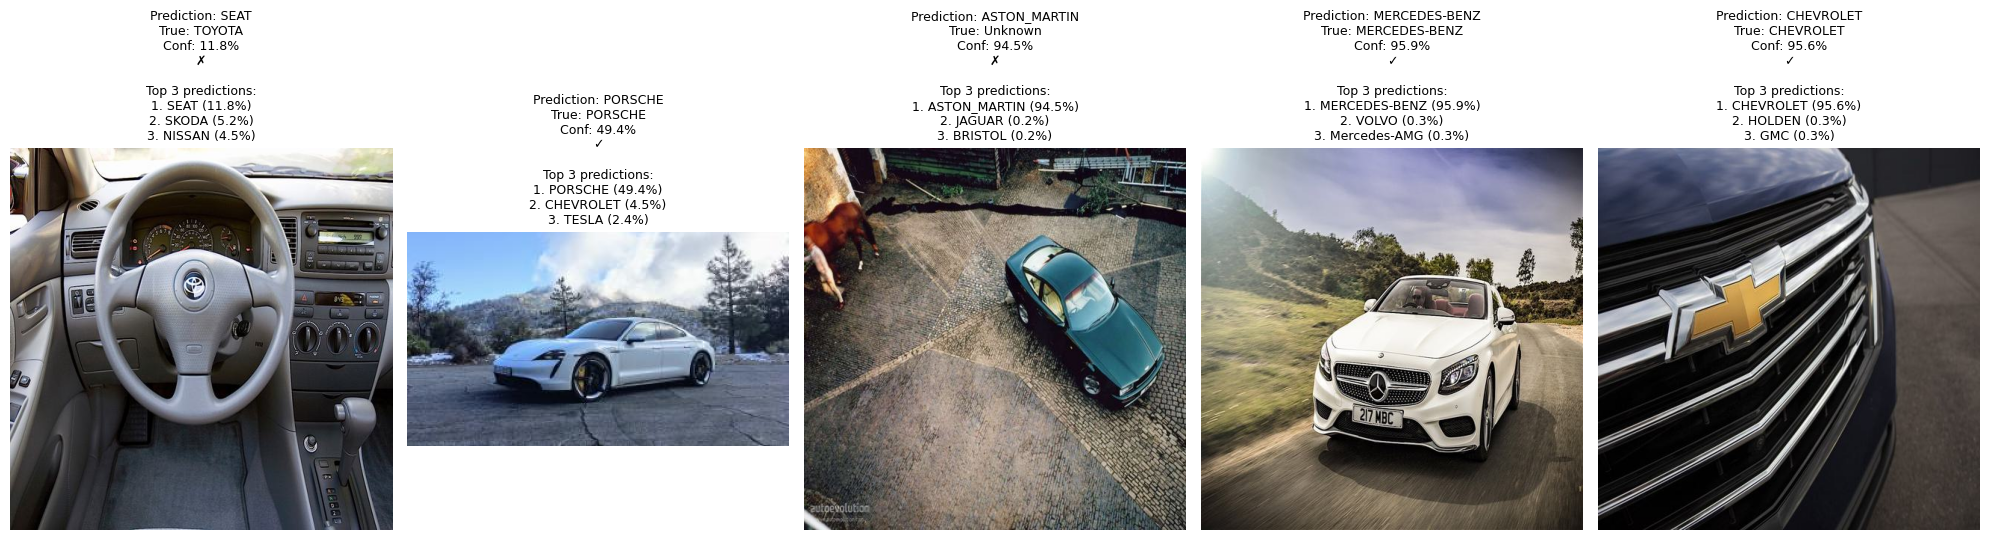


Accuracy on sample: 3/5 (60.0%)
Model device: privateuseone:0
Found 6 images in test directory
Model has 95 output classes
Final layer output size: 95


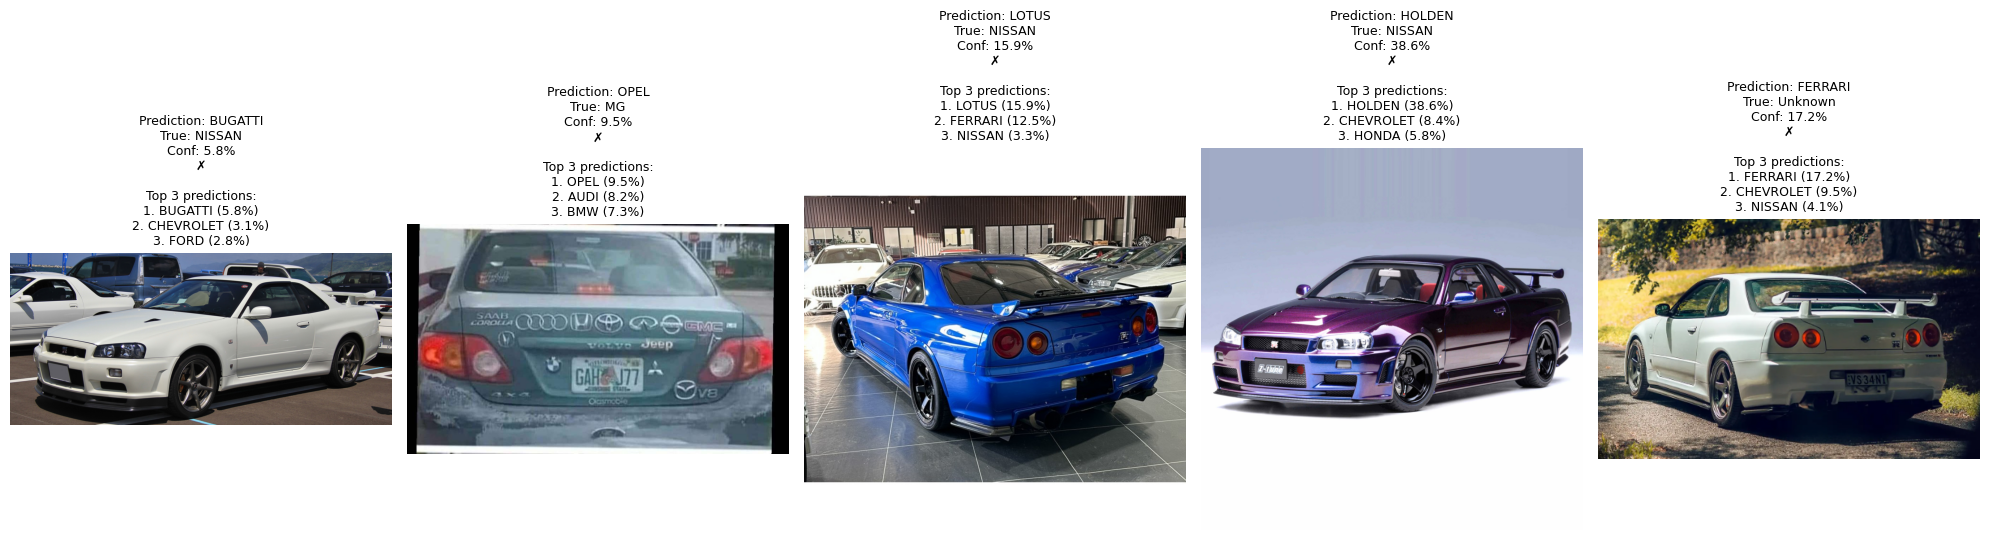


Accuracy on sample: 0/5 (0.0%)


[{'file': 'Nissan_Skyline_GT-R_R34_V_Spec_II.jpg',
  'true': 'NISSAN',
  'pred': 'BUGATTI',
  'confidence': 5.8127980679273605,
  'correct': False},
 {'file': '46l7w1otmgi61.jpg',
  'true': 'MG',
  'pred': 'OPEL',
  'confidence': 9.535673260688782,
  'correct': False},
 {'file': 'nissan-skyline-r34-gt-r-vspec-sale.jpg',
  'true': 'NISSAN',
  'pred': 'LOTUS',
  'confidence': 15.909907221794128,
  'correct': False},
 {'file': 'Nissan_R34.jpg',
  'true': 'NISSAN',
  'pred': 'HOLDEN',
  'confidence': 38.62581551074982,
  'correct': False},
 {'file': 'r34.PNG',
  'true': 'Unknown',
  'pred': 'FERRARI',
  'confidence': 17.20430999994278,
  'correct': False}]

In [518]:
# Testing the new model

def test_model_with_images(model, class_names, device, test_dir, num_images=5, brand_list=None):
    """Test the retrained model with some random images with enhanced error checking"""
    # Set up transforms - keeping your original transform
    test_transform = data_transforms['test']
    
    # Verify model is in eval mode
    model.eval()
    print(f"Model device: {next(model.parameters()).device}")
    
    # Get random images with better error handling
    try:
        image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not image_files:
            print(f"No image files found in {test_dir}")
            return
            
        # Print some diagnostics
        print(f"Found {len(image_files)} images in test directory")
        print(f"Model has {len(class_names)} output classes")
        print(f"Final layer output size: {list(model.modules())[-1].out_features}")
        
        # Sample images
        sample_images = random.sample(image_files, min(num_images, len(image_files)))
        
    except Exception as e:
        print(f"Error accessing test directory: {e}")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 5))
    if len(sample_images) == 1:
        axes = [axes]
    
    # Track results
    results = []
    
    # Process each image
    for i, img_file in enumerate(sample_images):
        try:
            img_path = os.path.join(test_dir, img_file)
            
            # Load and preprocess image
            image = Image.open(img_path).convert('RGB')
            img_tensor = test_transform(image).unsqueeze(0).to(device)
            
            # Try to determine true brand from filename
            true_brand = "Unknown"
            # Use brand_list if provided, otherwise try to use all_brands global variable
            brand_reference = brand_list if brand_list is not None else all_brands
            
            for brand in brand_reference:
                if brand.lower() in img_file.lower():
                    true_brand = brand
                    break
            
            # Get prediction with error handling
            with torch.no_grad():
                outputs = model(img_tensor)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                probs = torch.nn.functional.softmax(logits, dim=1)[0]
                
                # Get top 3 predictions
                values, indices = torch.topk(probs, 3)
                top_preds = [(class_names[idx.item()], val.item() * 100) for idx, val in zip(indices, values)]
                
                confidence, pred_idx = torch.max(probs, 0)
                pred_brand = class_names[pred_idx.item()]
                conf_value = confidence.item() * 100
            
            # Display image with prediction
            axes[i].imshow(image)
            axes[i].axis('off')
            match = "✓" if pred_brand.replace('_', ' ').lower() == true_brand.lower() else "✗"
            
            title = f"Prediction: {pred_brand}\nTrue: {true_brand}\nConf: {conf_value:.1f}%\n{match}"
            # Add top 3 preds to title
            title += "\n\nTop 3 predictions:"
            for j, (name, score) in enumerate(top_preds):
                title += f"\n{j+1}. {name} ({score:.1f}%)"
                
            axes[i].set_title(title, fontsize=9)
            
            # Save result
            results.append({
                'file': img_file,
                'true': true_brand,
                'pred': pred_brand,
                'confidence': conf_value,
                'correct': pred_brand.replace('_', ' ').lower() == true_brand.lower()
            })
            
        except Exception as e:
            print(f"Error processing image {img_file}: {e}")
            if i < len(axes):
                axes[i].text(0.5, 0.5, f"Error: {str(e)}", 
                            ha='center', va='center', fontsize=9, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    correct = sum(1 for r in results if r['correct'])
    print(f"\nAccuracy on sample: {correct}/{len(results)} ({correct/len(results)*100:.1f}%)")
    return results

# First, recreate the model architecture
model = models.resnet50(weights='IMAGENET1K_V2')

# Recreate the architecture with the exact same structure
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, num_classes)
)

try:
    # Load model weights
    #model.load_state_dict(torch.load('retrained_model.pth'))
    model.load_state_dict(torch.load('best_resnet_car_classifier.pth'))
    print("Successfully loaded model weights")
    
    # Move model to device
    model = model.to(device)
    
    # Test the model
    test_results = test_model_with_images(
        model=model,
        class_names=class_names,
        device=device,
        test_dir='./images/cars5',
        num_images=5,
        brand_list=all_brands  # Pass explicitly to avoid dependency on global
    )
except Exception as e:
    print(f"Error testing model: {e}")

# Test the retrained model
test_model_with_images(
    model=model,  # Pass the model object, not the load_state_dict result
    class_names=class_names,
    device=device,
    test_dir='./images/cars4',
    num_images=5
)